# Template for Bayesian Optimization

# First some visualization

In [1]:
# Do not run this line more than once! Otherwise restart kernel
import os
print('Initial wdir: ' + os.getcwd())
os.chdir('../../../')
print('Current wdir: ' + os.getcwd())

Initial wdir: C:\Users\X053269\Repos\Template - ML\notebook\Renato\Templates
Current wdir: C:\Users\X053269\Repos\Template - ML


In [2]:
import pandas as pd
import numpy as np
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [3]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

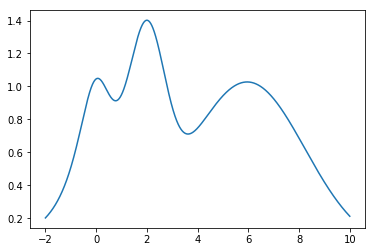

In [4]:
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y)

In [5]:
# functions for the nice plots below
def posterior(bo, x, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma

def plot_gp(bo, x, y):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x, bo.gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [6]:
# Initialize a Bayesian Optimization object. Pass the function to be optimized and the parameter boundaries in a dict.
bo = BayesianOptimization(target, {'x': (-2, 10)})

Maximize the passed function.
The algorithm first evaluates the function on "init_points" randomly chosen points.
He will do "n_iter" additional evaluations in order to approximate the maximum.
"xi" determines the "broadness" of the search. Maximizing with higher xi's (xi=0.1) is called exploration, as the function is explored. For lower xi (xi=0) the Algorithm tries to get the maximum, with the danger of being stuck in a local optimum.

The purpose of "kappa" is unknown to me....

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    0.74218 |    3.9676 | 
    2 | 00m00s |    0.72875 |    3.4022 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    3 | 00m01s |    0.21180 |   10.0000 | 
    4 | 00m00s |    0.20166 |   -2.0000 | 
    5 | 00m01s |    0.99886 |    6.4959 | 
    6 | 00m00s |    0.94491 |    0.5348 | 
    7 | 00m00s |    0.68790 |    7.9919 | 
    8 | 00m00s |    1.27471 |    1.5953 | 
    9 | 00m00s |    0.99901 |    5.4117 | 
   10 | 00m00s |    1.39111 |    2.1125 | 
   11 | 00m00s |    0.67865 |   -0.7068 | 
   12 | 00m00s |    1.24391 |    2.4487 | 


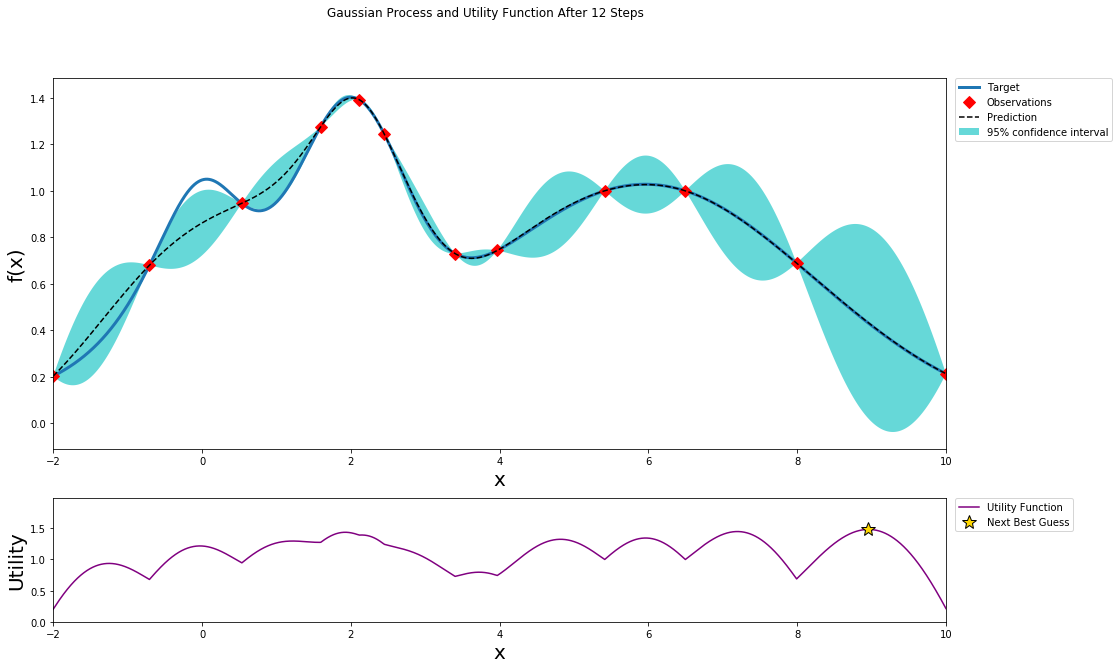

In [7]:
bo.maximize(init_points=2, n_iter=10, xi=1e-0, kappa=5)
plot_gp(bo, x, y)

Experimentiere mit Bayesian Optimization

In [85]:
from __future__ import print_function
from __future__ import division

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization

# Load data set and target values
data, target = make_classification(
    n_samples=1000,
    n_features=45,
    n_informative=12,
    n_redundant=7
)

# Define the function to be optimized (Cross Validation Score)
def svccv(C, gamma):
    val = cross_validate(
        SVC(C=C, gamma=gamma, random_state=2),
        data, y=target, scoring='f1', cv=2
    )['test_score'].mean()

    return val

# Do the same for the second classifier
def rfccv(n_estimators, min_samples_split, max_features):
    val = cross_validate(
        RFC(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=min(max_features, 0.999),
            random_state=2
        ),
        data, y=target, scoring='f1', cv=2
    )['test_score'].mean()
    return val

In [13]:
# Set gaussian process parameters
# This is an important step as it can change the output drastically!
gp_params = {"alpha": 1e-5}

# Instantiate optimizer
# Set parameter bounds
svcBO = BayesianOptimization(svccv,
    {'C': (0.001, 100), 'gamma': (0.0001, 0.1)})

# Explore predefined points (Exploration is performed as soon as BO.maximize is called)
svcBO.explore({'C': [0.001, 0.01, 0.1], 'gamma': [0.001, 0.01, 0.1]})

# No previous exploration done here
rfcBO = BayesianOptimization(
    rfccv,
    {'n_estimators': (10, 250),
    'min_samples_split': (2, 25),
    'max_features': (0.1, 0.999)}
)

Question:
How to choose the Gaussian Process parameter appropriately?

In [14]:
# perform optimization
print('\nSVC Classifier\n')
svcBO.maximize(n_iter=10, **gp_params)
print('-' * 53)

print('\nRFC Classifier\n')
rfcBO.maximize(n_iter=10, **gp_params)

print('-' * 53)
print('Final Results')
print('SVC: %f' % svcBO.res['max']['max_val'])
print('RFC: %f' % rfcBO.res['max']['max_val'])


SVC Classifier

Initialization
-----------------------------------------------------
 Step |   Time |      Value |         C |     gamma | 
    1 | 00m00s |    0.00000 |    0.0010 |    0.0010 | 


C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Program Files\Anaconda3\e

    2 | 00m00s |    0.00000 |    0.0100 |    0.0100 | 
    3 | 00m00s |    0.00000 |    0.1000 |    0.1000 | 
    4 | 00m00s |    0.60019 |   13.6797 |    0.0778 | 
    5 | 00m00s |    0.87890 |   80.1990 |    0.0414 | 
    6 | 00m00s |    0.60579 |   84.5163 |    0.0773 | 
    7 | 00m00s |    0.91086 |   83.6752 |    0.0071 | 
    8 | 00m00s |    0.89295 |   55.7929 |    0.0040 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         C |     gamma | 
    9 | 00m01s |    0.78611 |   62.5298 |    0.0001 | 
   10 | 00m01s |    0.16784 |   48.1785 |    0.1000 | 
   11 | 00m01s |    0.78325 |   22.1884 |    0.0001 | 
   12 | 00m01s |    0.16784 |   30.3269 |    0.1000 | 
   13 | 00m01s |    0.79072 |   70.1183 |    0.0001 | 
   14 | 00m01s |    0.79765 |  100.0000 |    0.0001 | 
   15 | 00m01s |    0.78402 |   39.1780 |    0.0001 | 
   16 | 00m00s |    0.79417 |   94.6466 |    0.0001 | 
   17 | 00m00s |    0.78479 |    7.8324 |   

C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 3, 'funcalls': 57, 'grad': array([-2.99338571e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2}
  ConvergenceWarning)


    7 | 00m02s |    0.82305 |         0.1000 |              2.0000 |       250.0000 | 
    8 | 00m03s |    0.82967 |         0.1505 |              2.0125 |       129.1228 | 
    9 | 00m02s |    0.78126 |         0.6985 |             24.7877 |        10.1302 | 
   10 | 00m02s |    0.81894 |         0.1155 |             24.9446 |       151.4607 | 
   11 | 00m03s |    0.82263 |         0.9990 |             25.0000 |        89.4488 | 
   12 | 00m03s |    0.83965 |         0.9773 |              2.0662 |        73.4667 | 
   13 | 00m06s |    0.84397 |         0.9334 |              2.0060 |       216.9598 | 


C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 3, 'funcalls': 45, 'grad': array([2.41933096e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2}
  ConvergenceWarning)


   14 | 00m03s |    0.84253 |         0.1820 |              2.1120 |       194.6499 | 
   15 | 00m04s |    0.83663 |         0.9965 |              3.7648 |       103.3585 | 


C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'funcalls': 46, 'grad': array([-2.49444991e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2}
  ConvergenceWarning)


-----------------------------------------------------
Final Results
SVC: 0.910856
RFC: 0.848622


Fragen:
- Wie kommt man zu den Punkten 5-8 bei SVC?
- Allgemeiner: wie wird initialisiert?

Antworten:
- Wenn nicht weiter spezifiziert wird zufällig initialisiert mit 5 Punkten. Spezifiziere mittels argument init_points.
- Man kann manuel mit BO.explore({'param1': [values1], 'param2': [values2]}) zusätzliche punkte initialisieren. values1 & values2 müssen dieselbe länge haben (Es wird kein GridSearch ausgeführt).

# Bayesian Optimization for Neural Nets

In [90]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [91]:
feature_size = len(data[0])

In [92]:
def nn_model_bo(nodes1=10, nodes2=10, dropout=0.2):
    model = Sequential()
    model.add(Dense(nodes1, input_dim=feature_size, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(nodes2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [93]:
# define the scoring function - cross validated score
def cv_score(model, x, y, scoring='accuracy', cv=3, n_jobs=3, fit_params=None):
    val = cross_validate(model,
                         x,
                         y=y,
                         scoring=scoring,
                         cv=cv,
                         n_jobs=n_jobs,
                         fit_params=fit_params)['test_score'].mean()
    return val

In [94]:
# define function to be optimized - function of the parameters only
def NN_BO(nodes1, nodes2, dropout):
    model = KerasClassifier(build_fn=nn_model_bo, nodes1=int(np.round(nodes1, 0)), nodes2=int(np.round(nodes2, 0)), dropout=float(dropout))
    fit_params = {"epochs": 40, "batch_size": 128, "validation_split": 0, "verbose": 0}
    score = cv_score(model, data, target, n_jobs=1, fit_params=fit_params)
    return score

In [95]:
# This parameter makes the optimization more stable and might be needed when numerical instabilities are encountered
gp_params = {"alpha": 1e-5}

In [96]:
NNBO = BayesianOptimization(NN_BO, {"nodes1": (5, 15), "nodes2": (5,15), "dropout": (0.1, 0.3)})

In [97]:
NNBO.maximize(n_iter=20, xi=0.05, **gp_params)

print('Final Results')
print(NNBO.res['max'])

Initialization
-----------------------------------------------------------------
 Step |   Time |      Value |   dropout |    nodes1 |    nodes2 | 
    1 | 00m20s |    0.73895 |    0.2868 |   10.0253 |   12.4252 | 
    2 | 00m24s |    0.77203 |    0.1098 |   11.8438 |    7.5716 | 
    3 | 00m23s |    0.68197 |    0.2872 |    6.4563 |    9.4561 | 
    4 | 00m25s |    0.75101 |    0.2866 |   14.2435 |   12.0160 | 
    5 | 00m18s |    0.74793 |    0.2389 |   13.0647 |   14.7068 | 
Bayesian Optimization
-----------------------------------------------------------------
 Step |   Time |      Value |   dropout |    nodes1 |    nodes2 | 
    6 | 00m26s |    0.72698 |    0.3000 |   15.0000 |    5.0000 | 
    7 | 00m30s |    0.70499 |    0.3000 |    9.6522 |    5.0000 | 
    8 | 00m30s |    0.69597 |    0.1000 |    5.0000 |   15.0000 | 
    9 | 00m33s |    0.74900 |    0.1000 |   13.8324 |    8.7980 | 
   10 | 00m28s |    0.80994 |    0.1000 |   15.0000 |   15.0000 | 
   11 | 00m31s |    0.75701

C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'funcalls': 51, 'grad': array([-1.99109854e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2}
  ConvergenceWarning)
C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 18, 'funcalls': 68, 'grad': array([2.99405729e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2}
  ConvergenceWarning)


   22 | 00m46s |    0.78297 |    0.1000 |   14.9733 |   14.8134 | 


C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 19, 'funcalls': 68, 'grad': array([-8.29941022e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2}
  ConvergenceWarning)


   23 | 00m45s |    0.77899 |    0.1000 |   15.0000 |   11.8629 | 


C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 18, 'funcalls': 67, 'grad': array([-3.62736992e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2}
  ConvergenceWarning)
C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'funcalls': 50, 'grad': array([-0.00014356]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2}
  ConvergenceWarning)
C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 6, 'funcalls': 49, 'grad': array([-0.00014065]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2}
  ConvergenceWarning)


   24 | 00m49s |    0.75900 |    0.1000 |   15.0000 |   15.0000 | 
   25 | 00m49s |    0.77297 |    0.1000 |   15.0000 |   13.6977 | 


C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'funcalls': 54, 'grad': array([-2.31132226e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2}
  ConvergenceWarning)
C:\Program Files\Anaconda3\envs\env_arag\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 6, 'funcalls': 55, 'grad': array([-1.53345996e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2}
  ConvergenceWarning)


Final Results
{'max_val': 0.8099416782051513, 'max_params': {'nodes2': 15.0, 'dropout': 0.1, 'nodes1': 15.0}}


Sometimes the algorithm is exploring the boundaries a lot (especially if many parameters are given). I am not 100% sure how to solve this issue, but I'd propose to
- do more initialization steps
- lower xi a bit